In [ ]:
from CoRe_Dataloader_From_Files_With_OvGN import (
    get_new_train_validation_test_datasets,
    get_new_train_validation_test_dataloaders,
)
from CoRe_Dataloader_ECSG import dataset
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import math
import torchinfo
import time
import numpy as np
import wandb
import datetime
from collections import OrderedDict
from torch import autograd
import matplotlib.pyplot as plt

In [ ]:
import torchmetrics as metrics
import pandas as pd

mae = metrics.MeanAbsoluteError()
mse = metrics.MeanSquaredError()
combined = metrics.MetricCollection(
    [mae, mse, metrics.MeanAbsolutePercentageError(), metrics.MeanSquaredLogError()]
)


def get_df_from_rdict(rdict):
    return pd.DataFrame(pd.Series(rdict).map(lambda x: x.cpu().item())).T

In [ ]:
# import vit
# import vit_pytorch
from vit_pytorch import vit_for_small_dataset as vit_sd
from vit_pytorch import vit as simple_vit
from vit_pytorch.deepvit import DeepViT


def init_model():
    # return simple_vit.ViT(image_size=400,
    #                patch_size=20,
    #                num_classes=19,
    #                dim=int(1024/2),
    #                depth=2,
    #                heads=8,
    #                mlp_dim=int(2048/2),
    #                channels=1).to("cuda:0")
    # return vit_sd.ViT(image_size=400,
    #                patch_size=20,
    #                num_classes=19,
    #                dim=1024,
    #                depth=4,
    #                heads=16,
    #                mlp_dim=int(2048/2),
    #                dropout = 0.1,
    #                emb_dropout = 0,
    #                channels=1).to("cuda:0")
    return DeepViT(
        image_size=400,
        patch_size=20,
        num_classes=2,
        dim=1024,
        depth=4,
        heads=16,
        mlp_dim=int(2048 / 2),
        dropout=0.1,
        emb_dropout=0.1,
        channels=1,
    ).to("cuda:0")

In [ ]:
dumstring = " "


def calc_metrics(model: torch.nn.Module, dl: DataLoader):
    model.eval()
    raw_output = []
    parameters = []
    with torch.no_grad():
        for batch, (sg, params) in enumerate(dl):
            sg = sg.to("cuda:0").float()
            sgsh = sg.shape
            sg = sg.view(sgsh[0], 1, sgsh[1], sgsh[2])

            params = params[:, 1:3].to("cuda:0")
            raw_output.append(model(sg).detach().cpu())
            parameters.append(params.cpu())
            print(f"{batch+1} / {len(dl)} { dumstring  * 20 }", end="\r")
    model.train()
    output = torch.vstack(raw_output)
    parameters = torch.concat(parameters, dim=0)
    return combined(output.cpu(), parameters.cpu())

In [ ]:
_, _, testds = get_new_train_validation_test_datasets(0.1, 0.000001)
testdl = DataLoader(testds, batch_size=1, shuffle=True)

In [ ]:
n = 253
plt.imshow(testds[n][0].cpu())
plt.colorbar()
plt.show()
print(testds[n][1])

In [ ]:
class LogCoshLoss(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, y_t, y_prime_t):
        ey_t = y_t - y_prime_t
        return torch.mean(torch.log(torch.cosh(ey_t + 1e-12)))


class XTanhLoss(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, y_t, y_prime_t):
        ey_t = y_t - y_prime_t
        return torch.mean(ey_t * torch.tanh(ey_t))


class XSigmoidLoss(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, y_t, y_prime_t):
        ey_t = y_t - y_prime_t
        return torch.mean(2 * ey_t / (1 + torch.exp(-ey_t)) - ey_t)

In [ ]:
model = init_model()
startlr = 3e-5
optimizer = optim.AdamW(params=model.parameters(), lr=startlr)
optimizer1 = optim.NAdam(params=model.parameters(), lr=startlr)
step_scheduler = optim.lr_scheduler.MultiStepLR(
    optimizer, milestones=[1, 2, 3, 4], gamma=0.5
)
# at the end of 600 epochs, the learning rate is 0.000,002,62
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.8)
scheduler_pl = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer=optimizer, mode="max", factor=0.7, patience=35, verbose=True
)
l1 = nn.L1Loss(reduction="sum")
l2 = nn.MSELoss(reduction="sum")
lcosh = LogCoshLoss()
ltanh = XTanhLoss()
xsig = XSigmoidLoss()
lossfn = lambda x, y: l1(x, y) + l2(x, y) + lcosh(x, y) + ltanh(x, y) + xsig(x, y)

In [ ]:
def to_seconds(s):
    return f"{s//3600}H:{(s%3600)//60}M:{round(s%60,3)}S"


def ismult(n, div):
    return bool(1 >> (n % div))

In [ ]:
def save_model(best_model, config, m1, m2, m1name="l1", m2name="l2"):
    try:
        torch.save(
            best_model,
            f"./saved_models/ViT/WithNoise/best_model_state_dict_ViT_regressor_for{config.run_name}_stime_{config.start_time.replace(':', '-')}__{m1name}_{m1}__{m2name}_{m2}.pt",
        )
        print("\nSAVING MODEL")
    except:
        wandb.alert(level="warning", title="OUT OF MEMORY")

In [ ]:
def train_eval_model(config, train_dl, test_dl, adam=True, nadam=False):
    min_mae, min_mse = float("inf"), float("inf")
    ldl = len(train_dl)
    results = pd.DataFrame()
    best_model = OrderedDict()
    for epoch in range(1, config.epochs + 1):
        print("Pre-Evaluation Finished; Starting Training")
        etime = time.time()
        for batch, (sg, params) in enumerate(train_dl):
            stime = time.time()
            sgsh = sg.shape
            sg = sg.to("cuda:0").to(torch.float).view(sgsh[0], 1, sgsh[1], sgsh[2])
            params = params[:, 1:3].to("cuda:0").to(torch.float)
            optimizer.zero_grad()
            outputs = model(sg)
            loss = lossfn(outputs, params)
            loss.backward()
            optimizer.step() if adam else None
            optimizer1.step() if nadam else None
            #
            torch.cuda.empty_cache()
            #
            wandb.log(
                {
                    "loss": loss.item(),
                    "batch_mae": mae(outputs.to("cpu"), params.to("cpu")),
                    "batch_mse": mse(outputs.to("cpu"), params.to("cpu")),
                    "lr": scheduler.get_last_lr()[0],
                    "epoch": epoch,
                }
            )

            print(
                f"{epoch:5}/{config.epochs:5} // {batch:5}/{ldl:5} | Loss: {loss.item():2.4},batch_mae:{mae(outputs.to('cpu'),params.to('cpu')):3.4}, lr:{scheduler.get_last_lr()[0]:1.5}, Time per Batch: {time.time()-stime:.3} seconds, Accumulated Time {to_seconds(round(time.time()-etime,3))}    ",
                end="\r",
                flush=True,
            )

            if (batch - 1) % 5000 == 0:
                epoch_results = calc_metrics(model, test_dl)
                results = pd.concat([results, get_df_from_rdict(epoch_results)])
                min_mae = min(results["MeanAbsoluteError"])
                min_mse = min(results["MeanSquaredError"])
                #
                if epoch_results["MeanAbsoluteError"] <= min_mae:
                    best_model = model.state_dict()
                    save_model(
                        best_model,
                        config,
                        list(epoch_results.values())[0],
                        list(epoch_results.values())[1],
                    )

                wandb.log(
                    {"epoch": epoch, "lr": scheduler.get_last_lr()[0]}
                    | epoch_results
                    | {"MinimumMAE": min_mae, "MinimumMSE": min_mse}
                    | {"EpochTime": time.time() - etime}
                )
        #
        epoch_results = calc_metrics(model, test_dl)
        results = pd.concat([results, get_df_from_rdict(epoch_results)])
        #
        min_mae = min(results["MeanAbsoluteError"])
        min_mse = min(results["MeanSquaredError"])
        #
        scheduler.step()
        step_scheduler.step()
        scheduler_pl.step(min_mae)

        if epoch_results["MeanAbsoluteError"] <= min_mae:
            best_model = model.state_dict()
            save_model(
                best_model,
                config,
                list(epoch_results.values())[0],
                list(epoch_results.values())[1],
            )
        #

        wandb.log(
            {"epoch": epoch, "lr": scheduler.get_last_lr()[0]}
            | epoch_results
            | {"MinimumMAE": min_mae, "MinimumMSE": min_mse}
            | {"EpochTime": time.time() - etime}
        )

    epoch_results = calc_metrics(model, test_dl)
    results = pd.concat([results, get_df_from_rdict(epoch_results)])
    return min_mae, min_mse

In [ ]:
# uncomment for training
results = []
trials = 1
for i in range(trials):
    wandb.init(
        project="ViT-Regressor-With-Noise",
    )
    config = wandb.config
    config.run_name = wandb.run._run_id
    config = wandb.config
    config.epochs = 3
    config.inx = 400
    config.iny = 400
    config.lr = startlr
    config.trial = i + 1
    config.total_trials = trials
    config.best_model = OrderedDict()
    config.start_time = datetime.datetime.now().isoformat()
    config.savename = f"best_model_state_dict_at_for{config.run_name}_stime_{config.start_time.replace(':', '-')}__acc_max_acc__auc_auc.pt"
    train_dl, valid_dl, test_dl = get_new_train_validation_test_dataloaders()
    train_eval_model(wandb.config, train_dl, valid_dl, nadam=True)
    results.append(calc_metrics(model, test_dl))  # type: ignore
    if i != (trials - 1):
        model = init_model()

In [ ]:
torch.save(
    model.state_dict(),
    f"./saved_models/ViT/WithNoise/best_model_state_dict_ViT_regressor_11_07_2023",
)

In [ ]:
evaldl = test_dl

In [ ]:
model.eval()
totout = []
with torch.no_grad():
    for batch, (sg, params) in enumerate(evaldl):
        sg = sg.to("cuda:0").to(torch.float)
        sgsh = sg.shape
        sg = sg.view(sgsh[0], 1, sgsh[1], sgsh[2])
        modelout = model(sg).detach().cpu()
        params = params.to("cpu").to(torch.float)
        comb = torch.concat([modelout, params], dim=1)
        print(comb[1], modelout[1], params[1])
        print(batch, "finished")
        totout.append(comb)
model.train()
print(len(totout))

In [ ]:
all_params = torch.cat(totout)

In [41]:
import pandas as pd

df = pd.DataFrame(all_params.numpy())
df = df.rename(
    columns={
        0: "PM1",
        1: "PM2",
        2: "EOS",
        3: "M1",
        4: "M2",
        5: "SHFT",
        6: "SNR"
    }
)
df["combined"] = df["M1"] + df["M2"]
df["DiffM1"] = abs(df["M1"] - df["PM1"])
df["DiffM2"] = abs(df["M2"] - df["PM2"])
df["totDiff"] = df["DiffM1"] + df["DiffM2"]
df["avgDiff"] = df["totDiff"] / 2
df.to_csv("results.csv")
df.head()

,PM1,PM2,EOS,M1,M2,SHFT,SNR,combined,DiffM1,DiffM2,totDiff,avgDiff
0,1.392681,1.407794,16.0,1.349998,1.349998,-20.0,0.000605,2.699996,0.042683,0.057796,0.100479,0.050240
1,1.391142,1.395929,4.0,1.300000,1.300000,-90.0,0.000230,2.600000,0.091142,0.095929,0.187072,0.093536
2,1.378050,1.373854,6.0,1.300000,1.300000,-60.0,0.000355,2.600000,0.078050,0.073854,0.151904,0.075952
3,1.382635,1.370407,10.0,1.371733,1.371733,90.0,0.000805,2.743466,0.010902,0.001326,0.012228,0.006114
4,1.659225,1.115177,2.0,1.650924,1.100016,-50.0,0.000155,2.750940,0.008301,0.015161,0.023462,0.011731


In [42]:
df.head()

,PM1,PM2,EOS,M1,M2,SHFT,SNR,combined,DiffM1,DiffM2,totDiff,avgDiff
0,1.392681,1.407794,16.0,1.349998,1.349998,-20.0,0.000605,2.699996,0.042683,0.057796,0.100479,0.050240
1,1.391142,1.395929,4.0,1.300000,1.300000,-90.0,0.000230,2.600000,0.091142,0.095929,0.187072,0.093536
2,1.378050,1.373854,6.0,1.300000,1.300000,-60.0,0.000355,2.600000,0.078050,0.073854,0.151904,0.075952
3,1.382635,1.370407,10.0,1.371733,1.371733,90.0,0.000805,2.743466,0.010902,0.001326,0.012228,0.006114
4,1.659225,1.115177,2.0,1.650924,1.100016,-50.0,0.000155,2.750940,0.008301,0.015161,0.023462,0.011731


In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="darkgrid")

[Text(0.5, 1.0, 'Difference between predicted and actual masses'),
 Text(0.5, 0, 'Difference (solar masses)'),
 Text(0, 0.5, 'Count')]

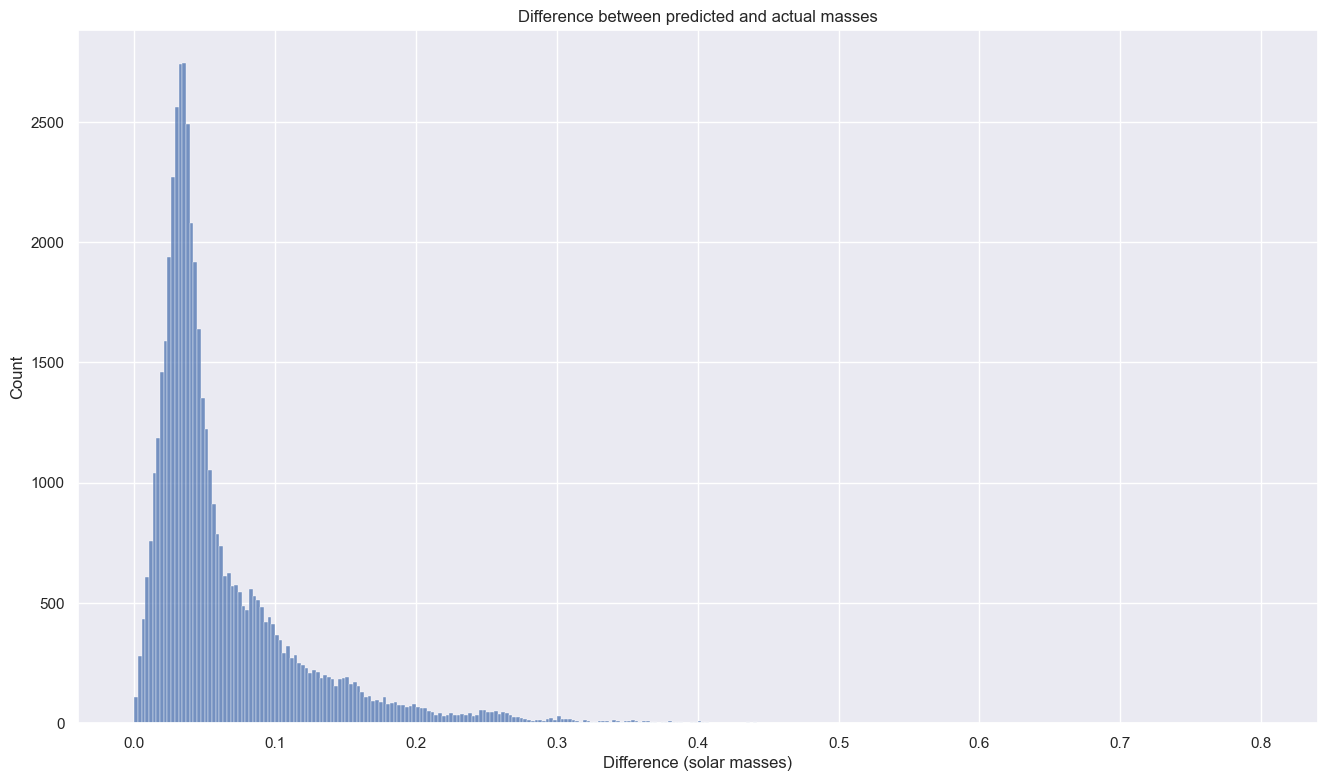

In [44]:
diffhist = sns.histplot(df["avgDiff"])
diffhist.set(
    title="Difference between predicted and actual masses",
    xlabel="Difference (solar masses)",
    ylabel="Count",
)

<AxesSubplot:xlabel='combined', ylabel='avgDiff'>

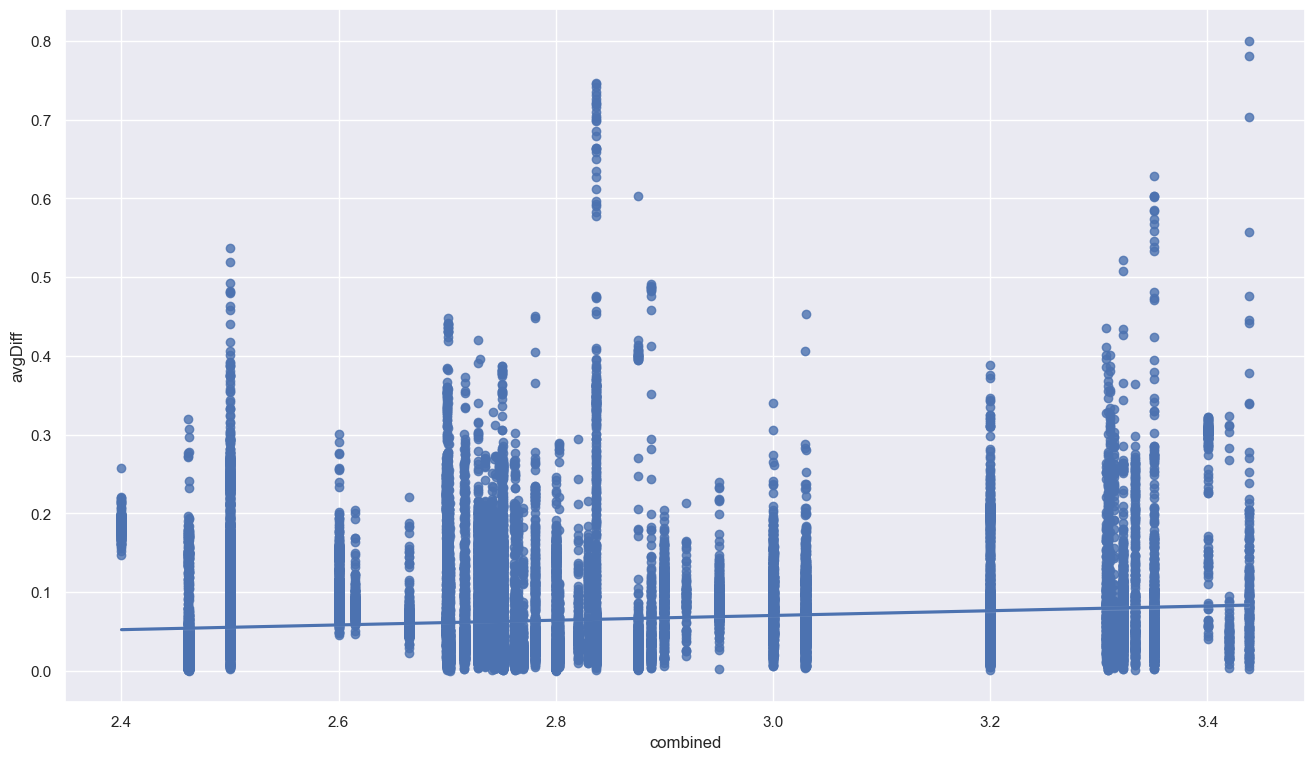

In [45]:
sns.regplot(x=df["combined"], y=df["avgDiff"])

<AxesSubplot:xlabel='M1', ylabel='DiffM1'>

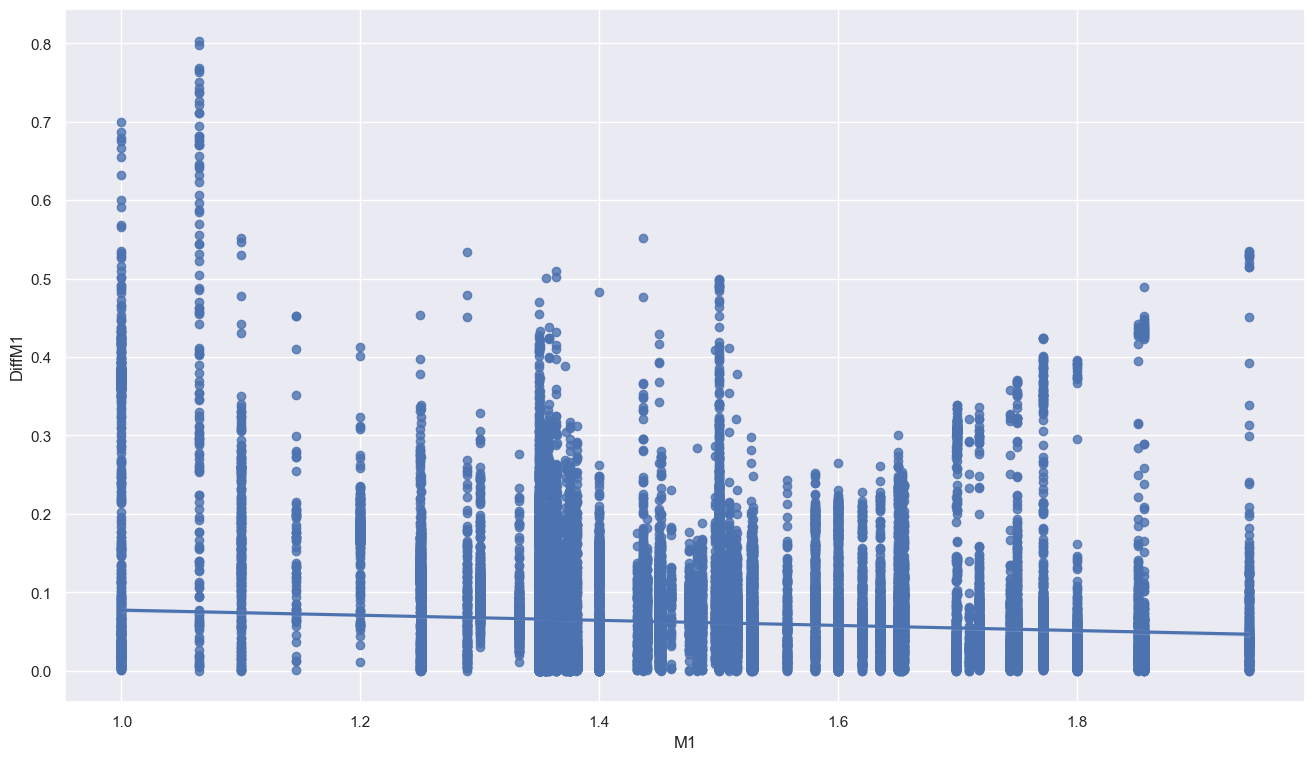

In [46]:
sns.regplot(x=df["M1"], y=df["DiffM1"])

<AxesSubplot:xlabel='M2', ylabel='DiffM2'>

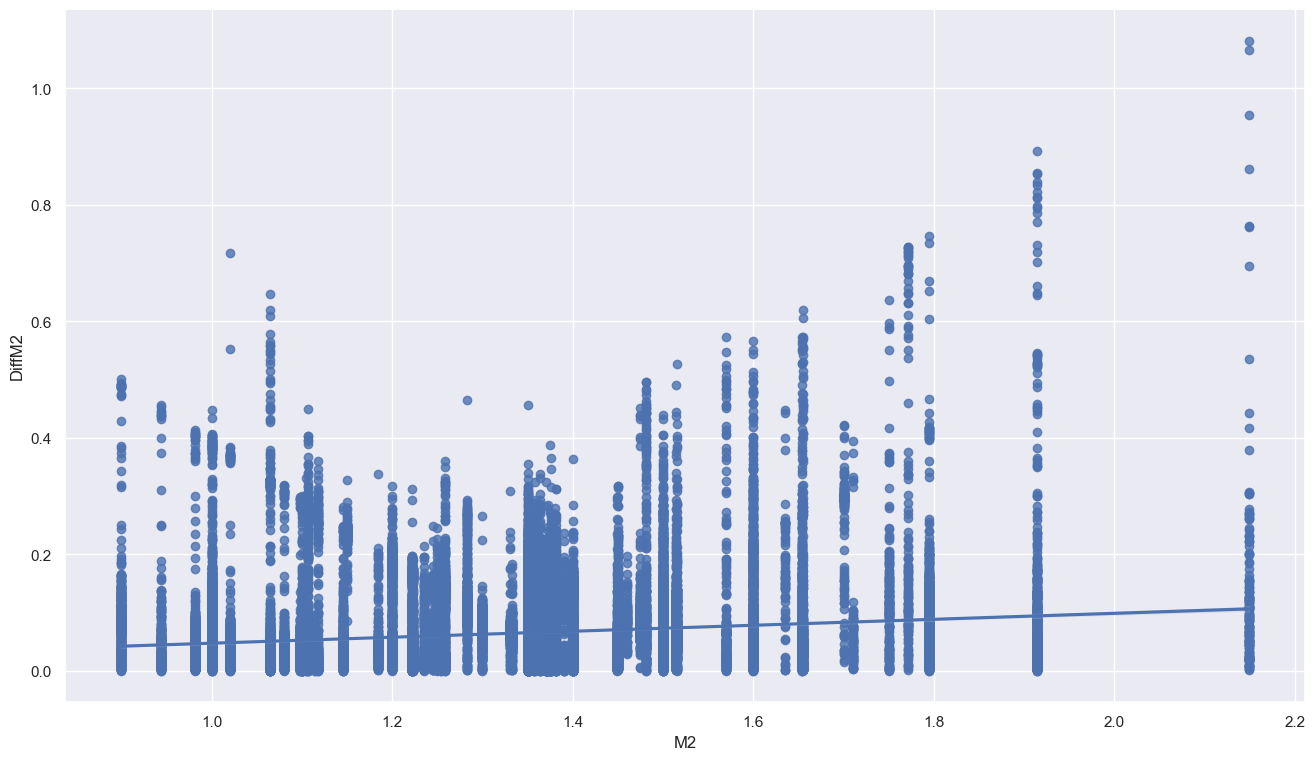

In [47]:
sns.regplot(x=df["M2"], y=df["DiffM2"])

In [48]:
df

,PM1,PM2,EOS,M1,M2,SHFT,SNR,combined,DiffM1,DiffM2,totDiff,avgDiff
0,1.392681,1.407794,16.0,1.349998,1.349998,-20.0,0.000605,2.699996,0.042683,0.057796,0.100479,0.050240
1,1.391142,1.395929,4.0,1.300000,1.300000,-90.0,0.000230,2.600000,0.091142,0.095929,0.187072,0.093536
2,1.378050,1.373854,6.0,1.300000,1.300000,-60.0,0.000355,2.600000,0.078050,0.073854,0.151904,0.075952
3,1.382635,1.370407,10.0,1.371733,1.371733,90.0,0.000805,2.743466,0.010902,0.001326,0.012228,0.006114
4,1.659225,1.115177,2.0,1.650924,1.100016,-50.0,0.000155,2.750940,0.008301,0.015161,0.023462,0.011731
...,...,...,...,...,...,...,...,...,...,...,...,...
49555,1.378717,1.392336,13.0,1.351462,1.351462,100.0,0.000855,2.702924,0.027255,0.040874,0.068129,0.034064
49556,1.402560,1.409300,3.0,1.400000,1.400000,-10.0,0.000130,2.800000,0.002560,0.009300,0.011860,0.005930
49557,1.627838,1.421727,6.0,1.635000,1.146000,-80.0,0.000880,2.781000,0.007162,0.275727,0.282889,0.141444
49558,1.391505,1.370746,16.0,1.350001,1.350001,80.0,0.000980,2.700002,0.041504,0.020745,0.062249,0.031125


[Text(0.5, 1.0, 'Correalation betweeen the Difference in M1 and Difference in M2'),
 Text(0.5, 0, 'Difference in Mass 1'),
 Text(0, 0.5, 'Diference in Mass 2')]

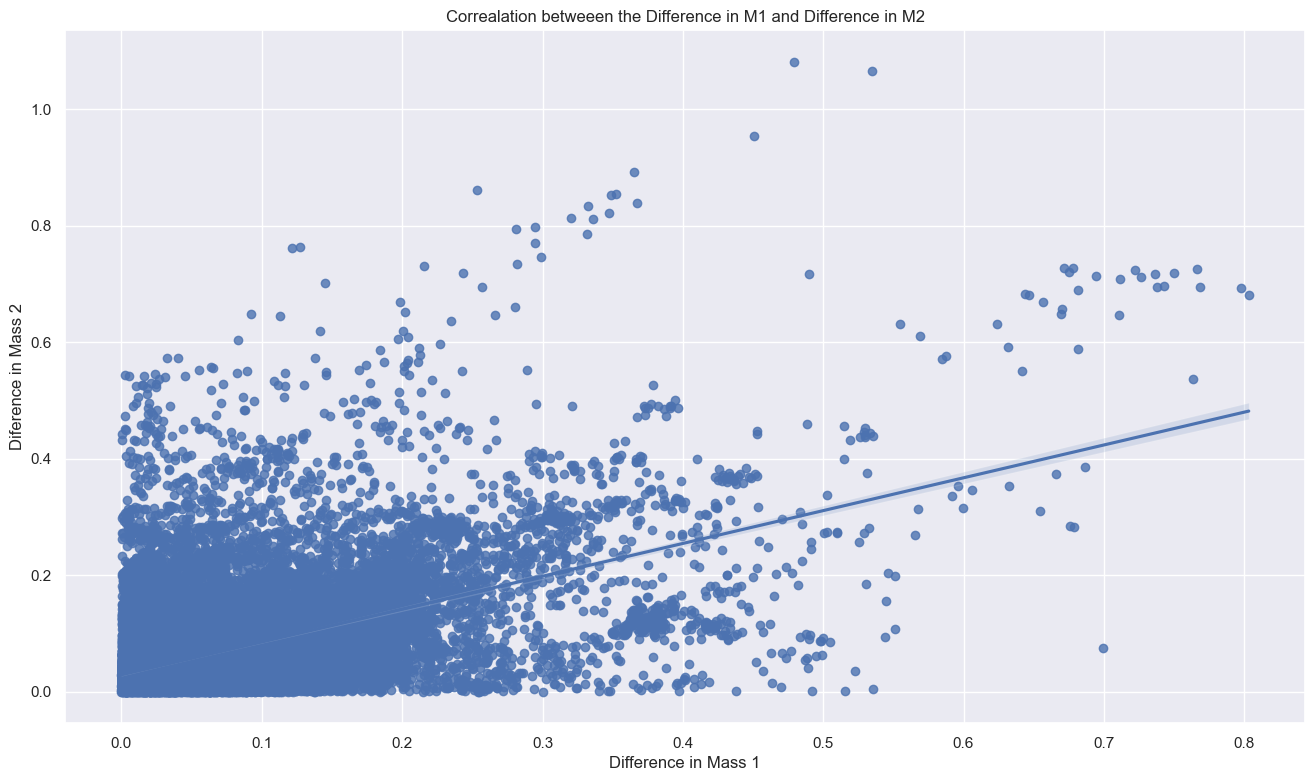

In [60]:
a = sns.regplot(data = df, x = "DiffM1", y = "DiffM2")
a.set(
    title = "Correalation betweeen the Difference in M1 and Difference in M2",
    xlabel = "Difference in Mass 1",
    ylabel = "Diference in Mass 2"
)

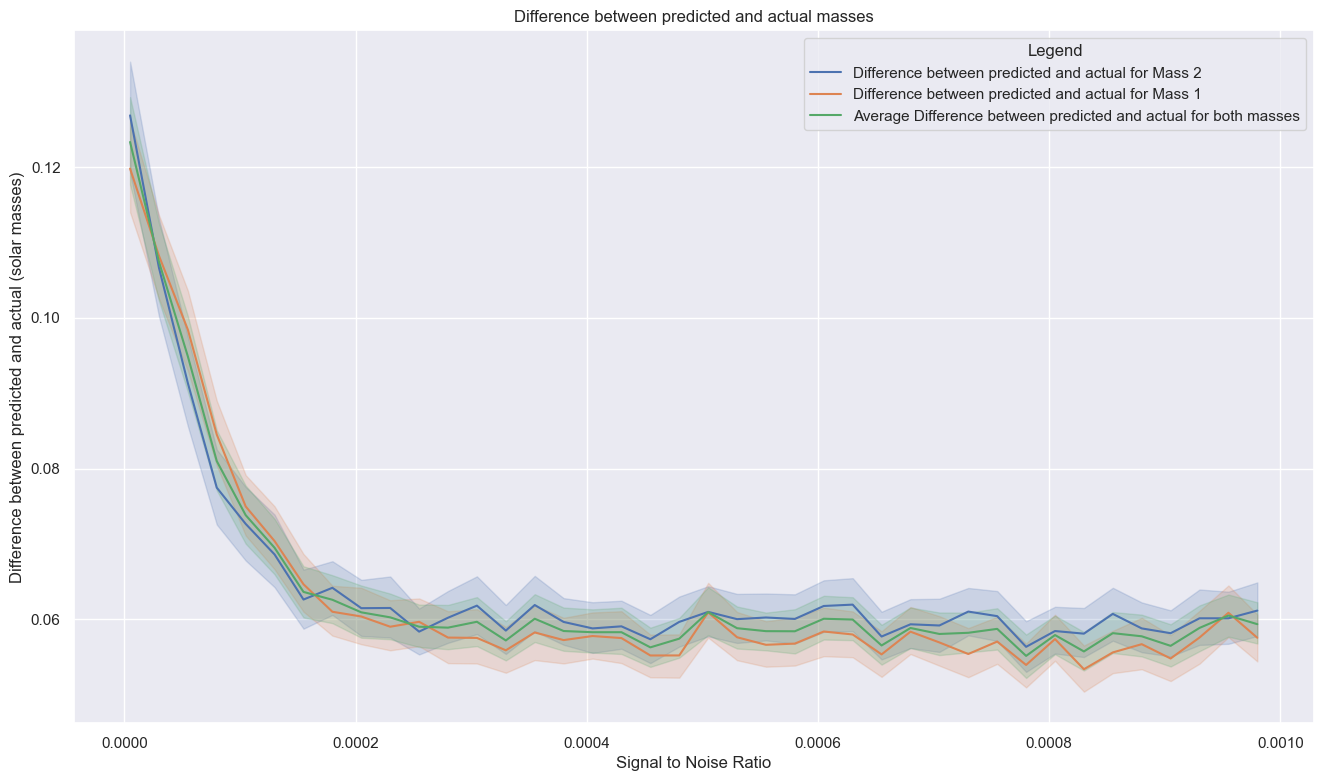

In [49]:
temparray = pd.melt(
    df[["SNR", "DiffM2", "DiffM1", "avgDiff"]].rename(
        columns={
            "SNR": "Signal to Noise Ratio",
            "DiffM2": "Difference between predicted and actual for Mass 2",
            "DiffM1": "Difference between predicted and actual for Mass 1",
            "avgDiff": "Average Difference between predicted and actual for both masses",
        }
    ),
    id_vars=["Signal to Noise Ratio"],
)
a = sns.lineplot(data=temparray, x="Signal to Noise Ratio", y="value", hue="variable")
a.set(
    title="Difference between predicted and actual masses",
    xlabel="Signal to Noise Ratio",
    ylabel="Difference between predicted and actual (solar masses)",
)
new_title = "Legend:"
# replace labels
plt.legend(title="Legend", loc="upper right")
sns.set(rc={"figure.figsize": (16, 9)})

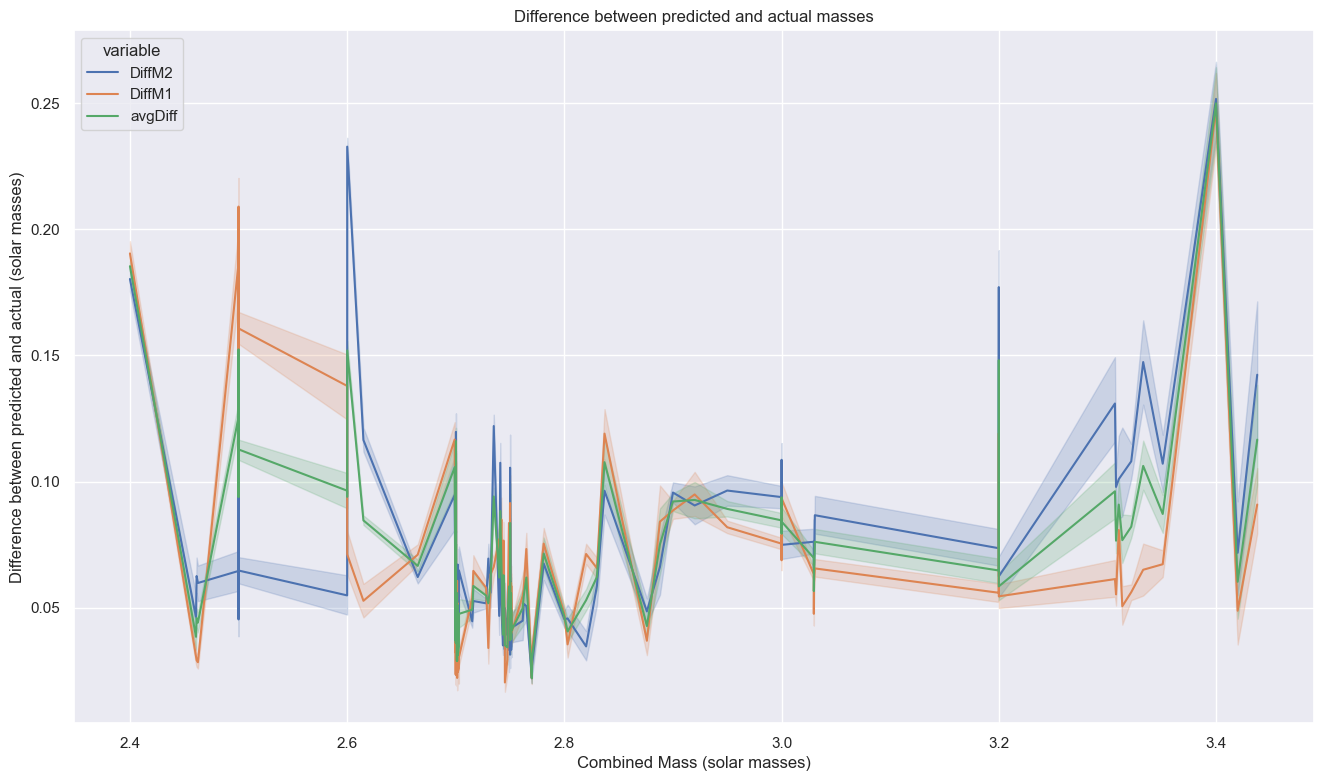

In [50]:
a = sns.lineplot(
    data=pd.melt(df[["combined", "DiffM2", "DiffM1", "avgDiff"]], id_vars=["combined"]),
    x="combined",
    y="value",
    hue="variable",
)
a.set(
    title="Difference between predicted and actual masses",
    xlabel="Combined Mass (solar masses)",
    ylabel="Difference between predicted and actual (solar masses)",
)
sns.set(rc={"figure.figsize": (16, 9)})

[Text(0.5, 1.0, 'Difference between predicted and actual masses vs EOS'),
 Text(0.5, 0, 'Equation of State'),
 Text(0, 0.5, 'Difference between predicted and actual (solar masses)')]

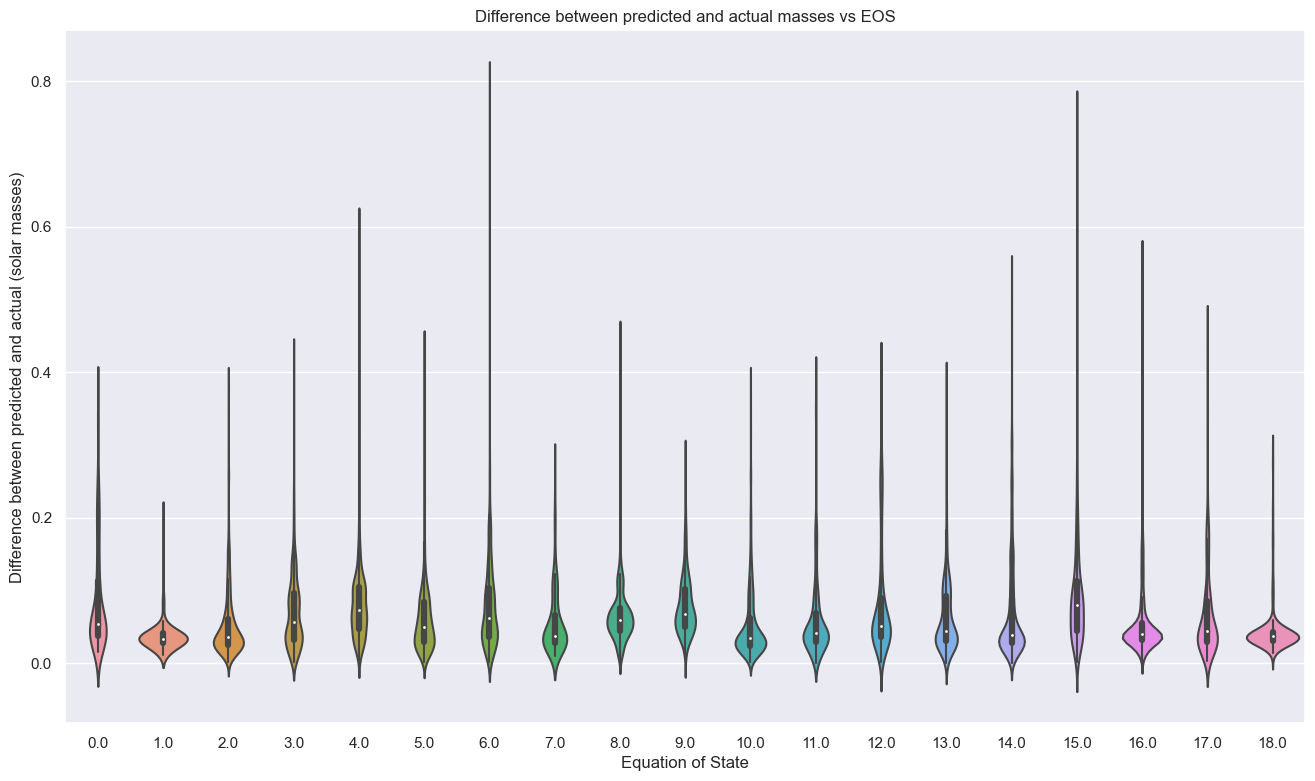

In [51]:
a = sns.violinplot(x=df["EOS"], y=df["avgDiff"])
a.set(
    title="Difference between predicted and actual masses vs EOS",
    xlabel="Equation of State",
    ylabel="Difference between predicted and actual (solar masses)",
)

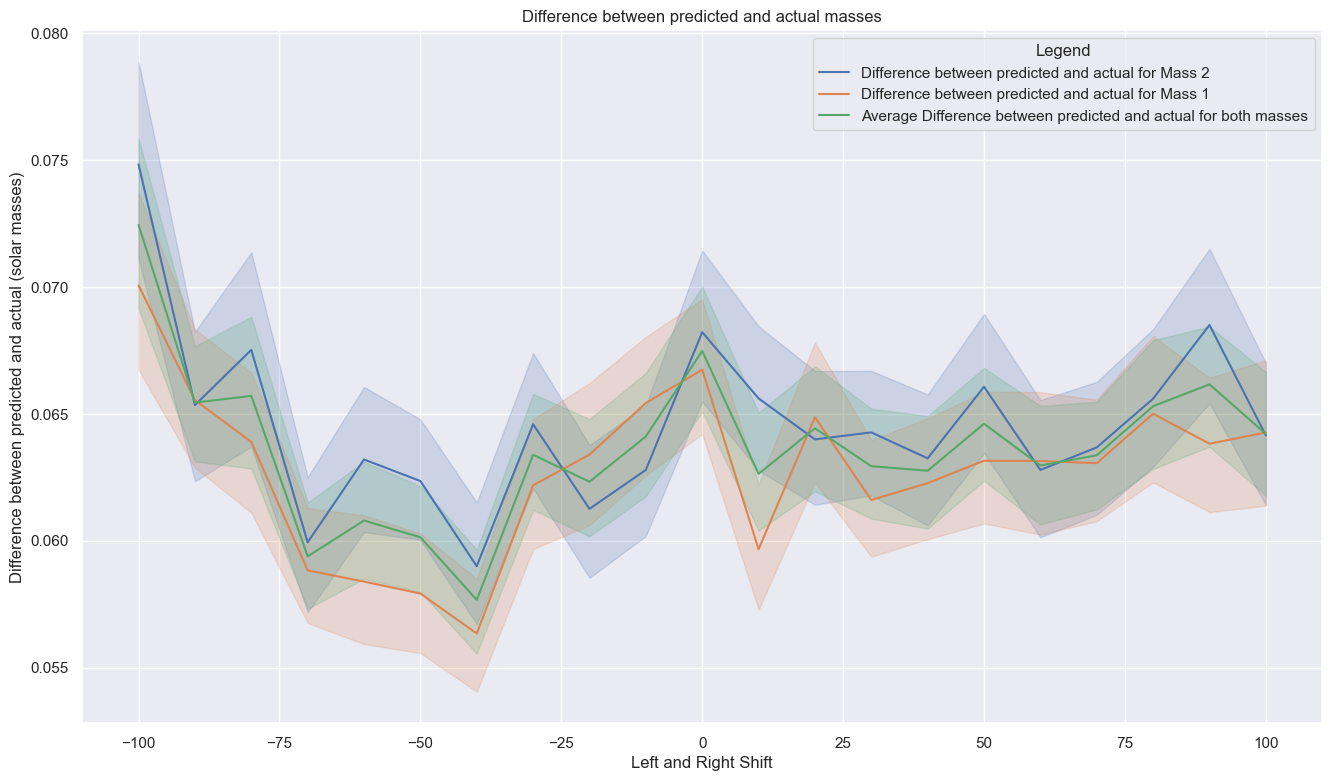

In [57]:
temparray = pd.melt(
    df[["SHFT", "DiffM2", "DiffM1", "avgDiff"]].rename(
        columns={
            "SHFT": "Left and Right Shift",
            "DiffM2": "Difference between predicted and actual for Mass 2",
            "DiffM1": "Difference between predicted and actual for Mass 1",
            "avgDiff": "Average Difference between predicted and actual for both masses",
        }
    ),
    id_vars=["Left and Right Shift"],
)
a = sns.lineplot(data=temparray, x="Left and Right Shift", y="value", hue="variable")
a.set(
    title="Difference between predicted and actual masses",
    xlabel="Left and Right Shift",
    ylabel="Difference between predicted and actual (solar masses)",
)
new_title = "Legend:"
# replace labels
plt.legend(title="Legend", loc="upper right")
sns.set(rc={"figure.figsize": (16, 9)})

In [52]:
for i in list(dataset.eosmap.items()):
    print(i[0], i[1])

2B 0
2H 1
ALF2 2
BHBlp 3
BLQ 4
BLh 5
DD2 6
ENG 7
G2 8
G2k123 9
H4 10
LS220 11
MPA1 12
MS1 13
MS1b 14
SFHo 15
SLy 16
SLy4 17
sly 18
